# Setup

In [ ]:
try:
  import geopandas as gpd
except ModuleNotFoundError as e:
  !pip install geopandas==0.10.0
  import geopandas as gpd
  if gpd.__version__ != "0.10.0":
    !pip install -U geopandas==0.10.0

# Exercise
 
1 - create the geodataframe of the [gas&oil stations](https://www.mise.gov.it/images/exportCSV/anagrafica_impianti_attivi.csv) of Italy 
  - data from the italian [Ministry of Economic Development](https://www.mise.gov.it)
  - count the total of the gas&oil stations for each muncipality of Trentino

2 - identify the difference of municipalities in Trentino in the year 2019 with the year 2021
  - identify which municipalities are created from aggregation to others
  - find the biggest new municipality of Trentino and show all the italian municipalities with bordering it
  - create the macroarea of all the municipalities bordering with it
  - for each gas&oil station in the macro-area, calculate how many monumental trees have been within a 500m radius
  
3 - creates a polygon that contains all the monumental trees inside the area
  - identify all the gas&oil stations in this area which are within 2km of each other
  - save the polygon in geopackage with the attribute "description" with the name of the gas&oil station

---

# Solutions

## learning objectives
* repeat the concepts on the previous lesson
* errors with the simplified boundaries
* convex_hull
* nearest_points


--- 

### Import of the packages

In [128]:
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None

# create the geodataframe of the [gas&oil stations](https://www.mise.gov.it/images/exportCSV/anagrafica_impianti_attivi.csv) of Italy 

In [6]:
urlfile = "https://www.mise.gov.it/images/exportCSV/anagrafica_impianti_attivi.csv"
stations = pd.read_csv(urlfile,skiprows=1,sep=";",encoding="ISO-8859-1")

In [7]:
stations.head(5)

,idImpianto,Gestore,Bandiera,Tipo Impianto,Nome Impianto,Indirizzo,Comune,Provincia,Latitudine,Longitudine
0,46351,DI BENEDETTO CARBURANTI S.R.L.,DBCarburanti,Altro,VILLASETA,"VILLASETA S.S.115 KM 186,225",AGRIGENTO,AG,37.293320,13.569777
1,23778,ALFONSO DI BENEDETTO CARBURANTI LUBRIFICANTI SRL,Sicilpetroli,Altro,A. Di Benedetto srl Via Imera Ag,VIA IMERA 10 92100,AGRIGENTO,AG,37.312391,13.585913
2,49195,EOS SERVICES S.R.L. A SOCIO UNICO,Q8,Altro,AG021,VIA PETRARCA S.N. 92100,AGRIGENTO,AG,37.298234,13.589792
3,49460,EOS SERVICES S.R.L. A SOCIO UNICO,Q8,Altro,AG023,CONTRADA FONTANELLE S.N. 92100,AGRIGENTO,AG,37.326120,13.591820
4,49459,EOS SERVICES S.R.L. A SOCIO UNICO,Q8,Altro,AG024,VILLAGGIO MOSE' S.N.C. 92100,AGRIGENTO,AG,37.274324,13.614224


In [8]:
stations.columns

Index(['idImpianto', 'Gestore', 'Bandiera', 'Tipo Impianto', 'Nome Impianto',
       'Indirizzo', 'Comune', 'Provincia', 'Latitudine', 'Longitudine'],
      dtype='object')

In [9]:
columns = {
    'idImpianto': 'id',
    'Gestore': 'manager',
    'Bandiera':'company',
    'Tipo Impianto':'type',
    'Nome Impianto':'name',
    'Indirizzo':'address',
    'Comune':'city',
    'Provincia':'province',
    'Latitudine':'latitude',
    'Longitudine':'longitude'
}

In [10]:
stations.rename(columns=columns,inplace=True)

In [11]:
stations.head(3)

,id,manager,company,type,name,address,city,province,latitude,longitude
0,46351,DI BENEDETTO CARBURANTI S.R.L.,DBCarburanti,Altro,VILLASETA,"VILLASETA S.S.115 KM 186,225",AGRIGENTO,AG,37.293320,13.569777
1,23778,ALFONSO DI BENEDETTO CARBURANTI LUBRIFICANTI SRL,Sicilpetroli,Altro,A. Di Benedetto srl Via Imera Ag,VIA IMERA 10 92100,AGRIGENTO,AG,37.312391,13.585913
2,49195,EOS SERVICES S.R.L. A SOCIO UNICO,Q8,Altro,AG021,VIA PETRARCA S.N. 92100,AGRIGENTO,AG,37.298234,13.589792


In [12]:
geo_stations = gpd.GeoDataFrame(
    stations,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(stations.longitude, stations.latitude))

In [13]:
geo_stations[~geo_stations.geometry.is_valid].shape[0]

4

Error:<br/>
the values should be zero: the geodataframe should contains points.<br/>
Maybe therea are some rows where the values of latitude and lontigude aren't present 

In [14]:
stations.latitude.isnull().sum()

4

In [15]:
stations.longitude.isnull().sum()

4

8 ... the same value for the invalid geometries

In [16]:
stations = stations[~stations.latitude.isnull()]

In [17]:
geo_stations = gpd.GeoDataFrame(
    stations,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(stations.longitude, stations.latitude))

In [18]:
geo_stations[~geo_stations.geometry.is_valid].shape[0]

0

Now it's ZERO :)

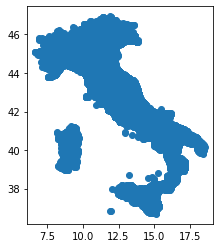

In [19]:
geo_stations.plot()
plt.show()

## count the total of the gas&oil stations for each muncipality of Trentino

On the GitHub repository of the course there are the geopackage files with the administrative limits of ISTAT [2020](https://github.com/napo/geospatial_course_unitn/raw/master/data/istat/istat_administrative_units_2020.gpkg) and [2021](https://github.com/napo/geospatial_course_unitn/raw/master/data/istat/istat_administrative_units_2021.gpkg) with generalized geometries

We download the data of both due the second issue of the exercise.  

In [20]:
url2021 = 'https://github.com/napo/geospatial_course_unitn/raw/master/data/istat/istat_administrative_units_generalized_2021.gpkg'
url2020 = 'https://github.com/napo/geospatial_course_unitn/raw/master/data/istat/istat_administrative_units_generalized_2020.gpkg'
istat2020 = "istat_administrative_units_generalized_2020.gpkg"
istat2021 = "istat_administrative_units_generalized_2021.gpkg"

In [21]:
r = requests.get(url2021, allow_redirects=True)
open(istat2021, 'wb').write(r.content)

42049536

In [22]:
r = requests.get(url2020, allow_redirects=True)
open(istat2020, 'wb').write(r.content)

23396352

In [23]:
import fiona
fiona.listlayers(istat2020)

['municipalities', 'provincies', 'regions', 'macroregions']

In [24]:
fiona.listlayers(istat2021)

['municipalities', 'provincies', 'regions', 'macroregions']

In [25]:
provincies2021 = gpd.read_file(istat2021,layer="provincies")

In [26]:
provincies2021.head(3)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,geometry
0,1,1,1,201,201,-,Torino,Torino,TO,Citta metropolitana,"MULTIPOLYGON (((411015.006 5049970.983, 411266..."
1,1,1,2,0,2,Vercelli,-,Vercelli,VC,Provincia,"MULTIPOLYGON (((438328.612 5087208.215, 439028..."
2,1,1,3,0,3,Novara,-,Novara,NO,Provincia,"MULTIPOLYGON (((460929.542 5076320.298, 461165..."


In [27]:
provincies2021.DEN_PROV.unique()

array(['-', 'Vercelli', 'Novara', 'Cuneo', 'Asti', 'Alessandria', 'Aosta',
       'Imperia', 'Savona', 'La Spezia', 'Varese', 'Como', 'Sondrio',
       'Bergamo', 'Brescia', 'Pavia', 'Cremona', 'Mantova', 'Bolzano',
       'Trento', 'Verona', 'Vicenza', 'Belluno', 'Treviso', 'Padova',
       'Rovigo', 'Udine', 'Gorizia', 'Trieste', 'Piacenza', 'Parma',
       "Reggio nell'Emilia", 'Modena', 'Ferrara', 'Ravenna',
       "Forli'-Cesena", 'Pesaro e Urbino', 'Ancona', 'Macerata',
       'Ascoli Piceno', 'Massa Carrara', 'Lucca', 'Pistoia', 'Livorno',
       'Pisa', 'Arezzo', 'Siena', 'Grosseto', 'Perugia', 'Terni',
       'Viterbo', 'Rieti', 'Latina', 'Frosinone', 'Caserta', 'Benevento',
       'Avellino', 'Salerno', "L'Aquila", 'Teramo', 'Pescara', 'Chieti',
       'Campobasso', 'Foggia', 'Taranto', 'Brindisi', 'Lecce', 'Potenza',
       'Matera', 'Cosenza', 'Catanzaro', 'Trapani', 'Agrigento',
       'Caltanissetta', 'Enna', 'Ragusa', 'Siracusa', 'Sassari', 'Nuoro',
       'Pordenone', '

choose the province of Trento

In [28]:
province_of_trento = provincies2021[provincies2021['DEN_PROV']=='Trento']

In [29]:
province_of_trento.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
boundary_province_of_trento = province_of_trento.to_crs(epsg=4326).geometry.values[0]

### plot it

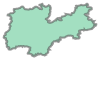

In [31]:
boundary_province_of_trento

In [32]:
stations_province_trento = geo_stations[geo_stations.within(boundary_province_of_trento)]

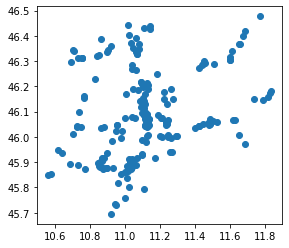

In [33]:
stations_province_trento.plot()
plt.show()

In [34]:
stations_province_trento.shape[0]

212

without spatial relationship 

In [35]:
stations.province.unique()

array(['AG', 'AL', 'AN', 'AO', 'AP', 'AQ', 'AR', 'AT', 'AV', 'BA', 'BG',
       'BI', 'BL', 'BN', 'BO', 'BR', 'BS', 'BT', 'BZ', 'CA', 'CB', 'CE',
       'CH', 'CI', 'CL', 'CN', 'CO', 'CR', 'CS', 'CT', 'CZ', 'EN', 'FC',
       'FE', 'FG', 'FI', 'FM', 'FR', 'GE', 'GO', 'GR', 'IM', 'IS', 'KR',
       'LC', 'LE', 'LI', 'LO', 'LT', 'LU', 'MB', 'MC', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', nan, 'NO', 'NU', 'OG', 'OR', 'OT', 'PA', 'PC',
       'PD', 'PE', 'PG', 'PI', 'PN', 'PO', 'PR', 'PT', 'PU', 'PV', 'PZ',
       'RA', 'RC', 'RE', 'RG', 'RI', 'RM', 'RN', 'RO', 'SA', 'SI', 'SO',
       'SP', 'SR', 'SS', 'SV', 'TA', 'TE', 'TN', 'TO', 'TP', 'TR', 'TS',
       'TV', 'UD', 'VA', 'VB', 'VC', 'VE', 'VI', 'VR', 'VS', 'VT', 'VV'],
      dtype=object)

In [36]:
provincies2021[provincies2021['DEN_PROV']=='Trento']['SIGLA'].unique()

array(['TN'], dtype=object)

In [37]:
stations[stations['province']=='TN'].shape[0]

211

GRRR....<br/> 
212 in the geodataframe<br/>
211 in the dataframe 

In [38]:
stations_province_trento[stations_province_trento['province'] != 'TN']

,id,manager,company,type,name,address,city,province,latitude,longitude,geometry
21177,40236,SARNI S.R.L.,Agip Eni,Autostradale,ADIGE EST,"Autostrada A22 BRENNERO-MODENA, Km. 186.98, di...",BRENTINO BELLUNO,VR,45.695187,10.916713,POINT (10.91671 45.69519)


In [39]:
point_outside = stations_province_trento[stations_province_trento['province'] != 'TN']

In [40]:
point_outside.explore()

In [41]:
point_outside.geometry.within(boundary_province_of_trento)

21177    True
dtype: bool

In [42]:
province_of_trento.to_crs(epsg=4326).contains(point_outside.geometry.values[0])

21    True
dtype: bool

We need to use the *not* generalized version of the administrative limits of Italy 

the course offers two zip files with the shapefiles of the italian municipalites in [2020](https://github.com/napo/geospatial_course_unitn/raw/master/data/istat/shapefile_istat_municipalities_2020.zip) and [2021](https://github.com/napo/geospatial_course_unitn/raw/master/data/istat/shapefile_istat_municipalities_2020.zip) made by ISTAT

In [43]:
urlmunicipalities2021 = 'https://github.com/napo/geospatial_course_unitn/raw/master/data/istat/shapefile_istat_municipalities_2021.zip'

In [44]:
municipalities2021 = gpd.read_file(urlmunicipalities2021)

In [45]:
municipalities2021.head(3)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,SHAPE_LENG,Shape_Le_1,Shape_Area,geometry
0,1,1,1,201,201,1077,001077,Chiaverano,None,0,18164.369945,18164.236621,1.202212e+07,"POLYGON ((414358.390 5042001.044, 414381.796 5..."
1,1,1,1,201,201,1079,001079,Chiesanuova,None,0,10777.398475,10777.318814,4.118911e+06,"POLYGON ((394621.039 5031581.116, 394716.100 5..."
2,1,1,1,201,201,1089,001089,Coazze,None,0,41591.434852,41591.122092,5.657268e+07,"POLYGON ((364914.897 4993224.894, 364929.991 4..."


In [46]:
cod_prov_trento = provincies2021[provincies2021.DEN_PROV == 'Trento'].COD_PROV.values[0]

In [47]:
municipalities_trentino_2021 = municipalities2021[municipalities2021.COD_PROV == cod_prov_trento]

In [48]:
province_of_trento = italy = municipalities_trentino_2021.dissolve(by='COD_PROV')
%time

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.29 µs


In [49]:
boundary_province_of_trento = province_of_trento.to_crs(epsg=4326).geometry.values[0]

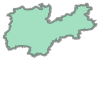

In [50]:
boundary_province_of_trento

In [51]:
stations_province_trento = geo_stations[geo_stations.within(boundary_province_of_trento)]

In [52]:
stations_province_trento.shape[0]

211

the total is right ;)

In [53]:
point_outside.geometry.within(boundary_province_of_trento)

21177    False
dtype: bool

and also the spatial relationship
<br/>now we can count the number of gas&oil stations for each municipality of Trentino

with the pandas way

In [54]:
stations_by_municipalities = stations_province_trento.groupby(['city']).size().reset_index().rename(columns={0:'total'}).sort_values(['total','city'],ascending=[False,True])
%time

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.25 µs


In [55]:
stations_by_municipalities = stations_province_trento.groupby(['city']).size().reset_index().rename(columns={0:'total'}).sort_values(['total','city'],ascending=[False,True])


In [56]:
stations_by_municipalities

,city,total
89,TRENTO,32
73,ROVERETO,13
63,PERGINE VALSUGANA,8
46,LAVIS,7
3,ARCO,6
...,...,...
93,VIGO DI FASSA,1
95,VILLA AGNEDO,1
96,VILLA LAGARINA,1
97,VOLANO,1


but ... if the columns "city"  is not present?

In [57]:
del stations_province_trento['city'] #delete the column city

In [58]:
stations_province_trento.head(3)

,id,manager,company,type,name,address,province,latitude,longitude,geometry
18291,5169,CAMPION MARCO E C. S.A.S.,Esso,Strada Statale,CAMPION MARCO E C. S.A.S.,"Statale 12 dell'Abetone e del Brennero, Km. 34...",TN,45.803566,11.019186,POINT (11.01919 45.80357)
18292,7317,FERRARI ATTILIO,Pompe Bianche,Altro,FERRARI ATTILIO,CORSO VERONA 22 38061,TN,45.757343,10.999531,POINT (10.99953 45.75734)
18293,23796,RO-MA SNC DI GIULIO ROPELE,Agip Eni,Altro,ENI-AGIP,STRADA PROVINCIALE 90 DESTRA ADIGE KM. 18 + 15...,TN,45.989288,11.097397,POINT (11.09740 45.98929)


reconstruct the name of the city associated for each location

In [59]:
def getNameCity(point,cities):
    name = cities[cities.to_crs(epsg=4326).contains(point)].COMUNE.values[0]
    return name

In [60]:
stations_province_trento['city'] = stations_province_trento.geometry.apply(lambda point: getNameCity(point,municipalities_trentino_2021))
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [61]:
stations_province_trento.head(3)

,id,manager,company,type,name,address,province,latitude,longitude,geometry,city
18291,5169,CAMPION MARCO E C. S.A.S.,Esso,Strada Statale,CAMPION MARCO E C. S.A.S.,"Statale 12 dell'Abetone e del Brennero, Km. 34...",TN,45.803566,11.019186,POINT (11.01919 45.80357),Ala
18292,7317,FERRARI ATTILIO,Pompe Bianche,Altro,FERRARI ATTILIO,CORSO VERONA 22 38061,TN,45.757343,10.999531,POINT (10.99953 45.75734),Ala
18293,23796,RO-MA SNC DI GIULIO ROPELE,Agip Eni,Altro,ENI-AGIP,STRADA PROVINCIALE 90 DESTRA ADIGE KM. 18 + 15...,TN,45.989288,11.097397,POINT (11.09740 45.98929),Aldeno


In [62]:
stations_by_municipalities = stations_province_trento.groupby(['city']).size().reset_index().rename(columns={0:'total'}).sort_values(['total','city'],ascending=[False,True])


In [63]:
stations_by_municipalities

,city,total
85,Trento,32
69,Rovereto,13
59,Pergine Valsugana,8
42,Lavis,7
4,Arco,6
...,...,...
87,Vallarsa,1
88,Vallelaghi,1
89,Vermiglio,1
90,Villa Lagarina,1


## identify the difference of municipalities in Trentino of year 2019 with year 2021


In [64]:
urlmunicipalities2019 = 'https://github.com/napo/geospatial_course_unitn/raw/master/data/istat/shapefile_istat_municipalities_2019.zip'
municipalities2019 = gpd.read_file(urlmunicipalities2019)

In [65]:
municipalities_trentino_2019 = municipalities2019[municipalities2019['COD_PROV'] == cod_prov_trento]

In [66]:
names2019 = list(municipalities_trentino_2019.COMUNE.unique())

In [67]:
names2021 = list(municipalities_trentino_2021.COMUNE.unique())

In [68]:
notpresentin2021 = list(set(names2019) - set(names2021))

In [69]:
notpresentin2021

['Daiano',
 'Cloz',
 'Carano',
 'Fondo',
 'Faedo',
 'Romallo',
 'Varena',
 'Castelfondo',
 'Revò',
 'Cagnò',
 'Brez',
 'Malosco']

In [70]:
notpresentin2019 = list(set(names2021) - set(names2019))

In [71]:
notpresentin2019

['Ville di Fiemme', "Borgo d'Anaunia", 'Novella']

In [72]:
old_municipalities_2019 = municipalities_trentino_2019[municipalities_trentino_2019.COMUNE.isin(notpresentin2021)]

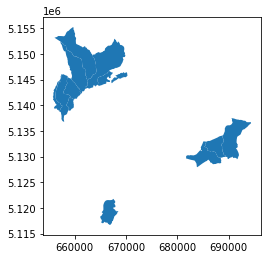

In [73]:
old_municipalities_2019.plot()
plt.show()

In [74]:
new_municipalities_2021 = municipalities_trentino_2021[municipalities_trentino_2021.COMUNE.isin(notpresentin2019)]

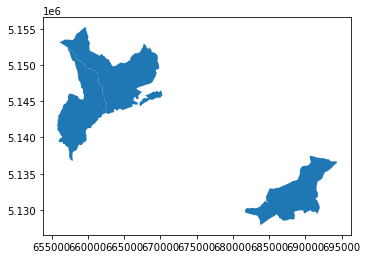

In [75]:
new_municipalities_2021.plot()
plt.show()

##  identify which municipalities are created from aggregation to others

In [76]:
def whereincluded(geometry, geometries_gdf):
    name = "not included"
    found = geometries_gdf[geometries_gdf.geometry.contains(geometry)]
    if len(found) > 0:
        name = found.COMUNE.values[0]
    return(name)

In [77]:
old_municipalities_2019['included_in'] = old_municipalities_2019.geometry.apply(lambda g: whereincluded(g,new_municipalities_2021))

In [78]:
old_municipalities_2019[['COMUNE','included_in']]

,COMUNE,included_in
724,Brez,Novella
2168,Carano,Ville di Fiemme
3247,Cagnò,Novella
3343,Malosco,Borgo d'Anaunia
3346,Daiano,Ville di Fiemme
4269,Cloz,Novella
4869,Romallo,Novella
5142,Castelfondo,Borgo d'Anaunia
5540,Revò,Novella
5607,Varena,Ville di Fiemme


Where is "Faedo" ?

In [79]:
faedo = old_municipalities_2019[old_municipalities_2019.COMUNE == 'Faedo']

In [80]:
faedo

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry,included_in
5652,2,4,22,0,22,22080,022080,Faedo,None,0,16440.165284,1.068038e+07,16440.047652,"POLYGON ((667690.769 5121538.436, 667726.269 5...",not included


In [81]:
faedo_geometry = faedo.geometry.values[0]

In [82]:
faedo_is_in = municipalities_trentino_2021[municipalities_trentino_2021.geometry.contains(faedo_geometry)]

In [83]:
faedo_new_municipality = faedo_is_in.COMUNE.values[0]

In [84]:
faedo_new_municipality

"San Michele all'Adige"

In [85]:
list_changed_municipalities = old_municipalities_2019[old_municipalities_2019.included_in != 'not included']

In [86]:
list_changed_municipalities = list(list_changed_municipalities.included_in.unique())

In [87]:
list_changed_municipalities.append(faedo_new_municipality)

In [88]:
list_changed_municipalities

['Novella', 'Ville di Fiemme', "Borgo d'Anaunia", "San Michele all'Adige"]

and we can do the same with the polygons

In [89]:
new_municipalities_trentino_2021 = municipalities_trentino_2021[municipalities_trentino_2021.COMUNE.isin(list_changed_municipalities)]

<AxesSubplot:>

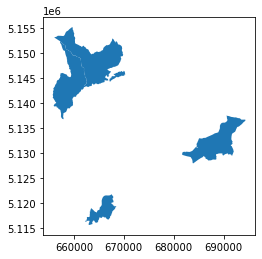

In [90]:
new_municipalities_trentino_2021.plot()

## find the biggest new municipality of Trentino and show all the italian municipalities with bordering it

In [91]:
biggest_new_municipality_trentino = new_municipalities_trentino_2021[new_municipalities_trentino_2021.geometry.area == new_municipalities_trentino_2021.geometry.area.max()]

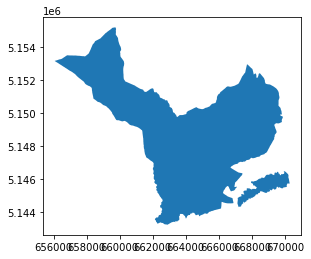

In [92]:
biggest_new_municipality_trentino.plot()
plt.show()

In [93]:
boundary_borgo_anaunia = biggest_new_municipality_trentino.geometry.values[0]

In [94]:
around_borgo_anaunia = municipalities2021[municipalities2021.touches(boundary_borgo_anaunia)]

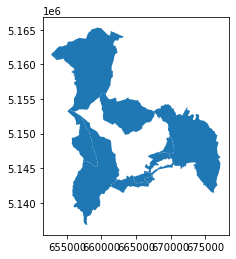

In [95]:
around_borgo_anaunia.plot()
plt.show()

## create the macroarea of all the municipalities bordering with it

In [96]:
new_area = around_borgo_anaunia.append(biggest_new_municipality_trentino).dissolve()

In [97]:
new_area = new_area[['geometry']]

In [98]:
new_area['name'] = "area of borgo d'anaunia and bordering municipalities"

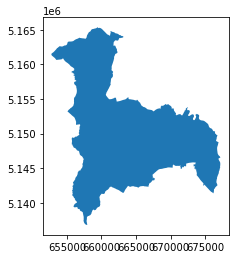

In [99]:
new_area.plot()
plt.show()

## for each gas&oil station in the macro-area, calculate how many monumental trees have been within a 500m radius

the dataset in GeoJSON of the italian monumental trees is created with the [code of the lesson 02](https://github.com/napo/geospatial_course_unitn/blob/master/code/lessons/02_Spatial_relationships_and_operations.ipynb)<br/>
You can find the dataset [here](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/monumental_trees/italian_monumental_trees_20210505.geojson)


In [100]:
macroarea_geometry = new_area.to_crs(epsg=4326).geometry.values[0]

In [101]:
stations_in_macroarea = geo_stations[geo_stations.within(macroarea_geometry)]

In [102]:
monumental_trees = gpd.read_file('https://github.com/napo/geospatial_course_unitn/raw/master/data/monumental_trees/italian_monumental_trees_20210505.geojson')

In [103]:
monumental_trees_in_macroarea = monumental_trees[monumental_trees.within(macroarea_geometry)]

In [104]:
def fivehundredfrom(point,points):
    present = False
    found = stations_in_macroarea[stations_in_macroarea.within(point)]
    if len(found) > 0:
        present = True
    return(present)

In [105]:
monumental_trees_in_macroarea.to_crs(epsg=3263).geometry.buffer(500).apply(lambda point: fivehundredfrom(point,stations_in_macroarea.to_crs(epsg=32632)))

298     False
330     False
3491    False
dtype: bool

it's normal that a gas&oil station is far away from a monumental tree :)

# creates a polygon that contains all the monumental trees inside the area

## convex hull
solution: create a convex hull<br/>
*In geometry, the convex hull or convex envelope or convex closure of a shape is the smallest convex set that contains it. The convex hull may be defined either as the intersection of all convex sets containing a given subset of a Euclidean space, or equivalently as the set of all convex combinations of points in the subset. For a bounded subset of the plane, the convex hull may be visualized as the shape enclosed by a rubber band stretched around the subset.* (source: [wikipedia](https://en.wikipedia.org/wiki/Convex_hull))

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/ConvexHull.svg/301px-ConvexHull.svg.png)

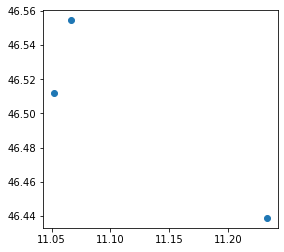

In [106]:
monumental_trees_in_macroarea.plot()
plt.show()

In [107]:
area_of_monumental_trees_in_macroarea = monumental_trees_in_macroarea.unary_union.convex_hull

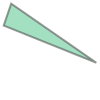

In [108]:
area_of_monumental_trees_in_macroarea

## identify all the gas&oil stations in this area which are within 2km of each other

In [109]:
stations_in_area_monumental_trees = stations_in_macroarea[stations_in_macroarea.within(area_of_monumental_trees_in_macroarea)]

In [110]:
len(stations_in_area_monumental_trees)

0

In [111]:
stations_out_area_monumental_trees = stations_in_macroarea[~stations_in_macroarea.within(area_of_monumental_trees_in_macroarea)]

In [112]:
len(stations_out_area_monumental_trees)

9

## nearest points

In [122]:
from shapely.ops import nearest_points

shapely offers a method to identify the nearest points between two geometries<br/>
Documentation [here](https://shapely.readthedocs.io/en/stable/manual.html#shapely.ops.nearest_points)


In [129]:
def get_nearest_id(id, points):
    # Create a union of points (multipoint geometry
    multipoints = points[points.id != id]["geometry"].unary_union
    # identify the starting point
    point = points[points.id == id]
    # find the nearest points
    nearest_geoms = nearest_points(point['geometry'].values[0], multipoints)
    # get corresponding values of the nearest point
    # note: in the position 0 there is the starting point
    nearest_data = points[points["geometry"] == nearest_geoms[1]]
    # extract the id of the nearest point
    nearest_id = nearest_data['id'].values[0]
    return (nearest_id)


In [130]:
stations_in_macroarea['id_nearest'] = stations_in_macroarea['id'].apply(lambda x :get_nearest_id(x,stations_in_macroarea))

In [131]:
stations_in_macroarea

,id,manager,company,type,name,address,city,province,latitude,longitude,geometry,id_nearest,distance_to_nearest
3454,7866,GATTERER SNC DI GATTERER GUENTHER & CO.,Agip Eni,Altro,ENI,STRADA DI CIRCONVALLAZIONE 4,APPIANO SULLA STRADA DEL VINO,BZ,46.456748,11.268874,POINT (11.26887 46.45675),27263,0.000000
3455,7923,"MEBO RAST DES KOMPATSCHER RICHARD & CO., KG",Agip Eni,Altro,MEBORAST,ME-BO CORSIA EST SNC 39050,APPIANO SULLA STRADA DEL VINO,BZ,46.494485,11.281658,POINT (11.28166 46.49449),49587,0.000000
3456,49587,MEBORAST 2 S.R.L.,Agip Eni,Strada Statale,MEBORAST,"238 delle Palade, Km. 221, SUD 39057",APPIANO SULLA STRADA DEL VINO,BZ,46.494556,11.281309,POINT (11.28131 46.49456),7923,0.000000
3457,9080,PICHLER KARL,Q8,Altro,Q8 des Karl Pichler,VIA CALDARO 8 39057,APPIANO SULLA STRADA DEL VINO,BZ,46.444788,11.260646,POINT (11.26065 46.44479),27263,1472.101058
3458,27263,TSCHIGG HELMUT,Esso,Altro,TSCHIGG HELMUT,VIA BOLZANO 5 39057,APPIANO SULLA STRADA DEL VINO,BZ,46.458640,11.261110,POINT (11.26111 46.45864),7866,0.000000
18310,23679,FLAIM CARLO,Repsol,Strada Statale,Flaim Carlo,"Statale 42 del Tonale e della Mendola, Km. 42,...",BREZ,TN,46.431569,11.107855,POINT (11.10786 46.43157),23500,0.000000
18351,23500,ZUCOL PIETRO,Esso,Altro,ESSO RAINER DI ZUCOL PIETRO,VIA PALADE 49 38013,FONDO,TN,46.436768,11.139896,POINT (11.13990 46.43677),12750,0.000000
18416,50275,GENTILINI MARCO,Api-Ip,Strada Statale,DISTRIBUTORE IP REVO',"42 del Tonale e della Mendola, Km. 192 + 370, ...",REVO',TN,46.393205,11.063137,POINT (11.06314 46.39321),23679,0.000000
18444,12750,BONANI GIULIANO,Agip Eni,Altro,bonani giuliano,VIA C. BATTISTI 1 38010,SARNONICO,TN,46.427077,11.141900,POINT (11.14190 46.42708),23500,2663.785902


In [150]:
def getdistance(id,points):
    points = points.to_crs(epsg=32632)
    point = points[points.id == id]
    id_nearest = point.id_nearest.values[0]
    point_nearest = points[points.id == id_nearest]
    from_geometry = point.geometry.values[0]
    to_geometry = point_nearest.geometry.values[0]
    dist = from_geometry.distance(to_geometry)
    return (dist)
